In [1]:
import numpy as np
import mlflow
import seaborn as sns

from restaurant_reviews_allergy.utils.mlflow_ import download_data
from restaurant_reviews_allergy.utils.data import read_review_file
from restaurant_reviews_allergy.utils.analysis import (calculate_weighted_sentiment, aggregate_sentiment_by_business,
                                                       aggregate_sentiment_by_business_allergy)
from restaurant_reviews_allergy.utils.geography import get_region_name, get_region

mlflow.set_tracking_uri('../mlruns')
mlflow.set_experiment('restaurant-reviews-allergy')
data_run_id = '9abaaa7705734bb082e6886e3d9296b7'

In [3]:
allergy_cols = ['is_allergy','is_celiac', 'is_intolerant', 'is_intolerance']
allergen_cols = ['is_dairy', 'is_egg', 'is_gluten', 'is_soy', 'is_peanut', 'is__nut', 
                 'is_shellfish','is_wheat', 'is_seafood']

data = download_data(data_run_id, 'data_with_sentiment.pkl')
businesses = read_review_file("business", n_rows=0)
data = data[(data[allergy_cols].sum(axis=1) > 0)].drop(allergy_cols, axis=1)
business_sentiment = aggregate_sentiment_by_business(data)
business_sentiment = business_sentiment.merge(
     businesses[['business_id', 'city', 'state', 'latitude', 'longitude']],
     on='business_id',
     how='left'
     )  
business_sentiment = get_region(business_sentiment)
business_sentiment = get_region_name(business_sentiment) 
business_sentiment.head(2)

/Users/kristenkeller/anaconda/envs/restaurant-reviews-allergy-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


Reading file business


,business_id,sentiment_score,sentiment_n_sentences,city,state,latitude,longitude,region_id,region_name
0,--9e1ONYQuAa-CB_Rrw7Tw,1.75,6,las-vegas,NV,36.123183,-115.169190,852986bbfffffff,las-vegas
1,--DaPTJW3-tB1vP-PfdTEg,0.00,1,toronto,ON,43.677807,-79.444674,852b9bc7fffffff,toronto


### What cities/states have best restaurants for allergies on average?

In [4]:
def get_groups_with_positive_sentiment(data, grouping_col):
    data = data \
        .groupby(grouping_col, as_index=False) \
        .agg({'sentiment_score': [np.median, 'count', 'mean']}) \
        .sort_values([('sentiment_score', 'mean')], ascending=False)
    return data

def get_groups_with_negative_sentiment(data, grouping_col):
    data = data \
        .groupby(grouping_col, as_index=False) \
        .agg({'sentiment_score': [np.median, 'count', 'mean']}) \
        .sort_values([('sentiment_score', 'mean')], ascending=True)
    return data

/Users/kristenkeller/anaconda/envs/restaurant-reviews-allergy-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'States with most allergy friendly restaurants'}, ylabel='mean rating'>

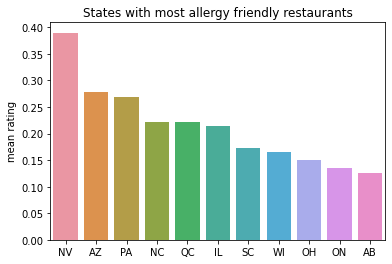

In [5]:
positive_states = get_groups_with_positive_sentiment(business_sentiment, 'state').head(20)
ax = sns.barplot(
    y=positive_states['sentiment_score']['mean'],
    x=positive_states['state']
    )
ax.set(
    title='States with most allergy friendly restaurants', 
    xlabel='', 
    ylabel='mean rating'
    )
ax

/Users/kristenkeller/anaconda/envs/restaurant-reviews-allergy-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Cities with most allergy frienly restaurants'}, xlabel='city - state (number of allergy-related sentences)', ylabel='mean rating'>

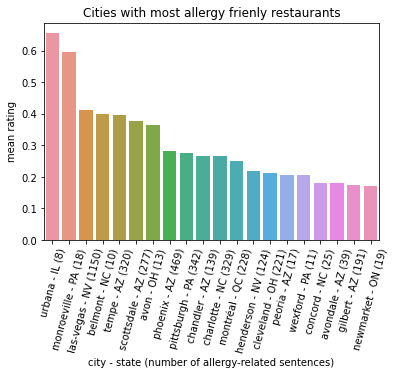

In [15]:
positive_cities = get_groups_with_positive_sentiment(business_sentiment, ['state','region_name'])
positive_cities = positive_cities[positive_cities['sentiment_score']['count'] > 5].head(20)

ax = sns.barplot(
    y=positive_cities['sentiment_score']['mean'],
    x=(positive_cities['region_name'] + ' - ' + positive_cities['state']) + \
        ' (' + positive_cities['sentiment_score']['count'].astype(str) + ')'
    )
ax.set(
    title='Cities with most allergy frienly restaurants', 
    xlabel='city - state (number of allergy-related sentences)', 
    ylabel='mean rating'
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax

/Users/kristenkeller/anaconda/envs/restaurant-reviews-allergy-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


<AxesSubplot:title={'center':'Cities with most allergy frienly restaurants'}, xlabel='city - state (number of allergy-related sentences)', ylabel='mean rating'>

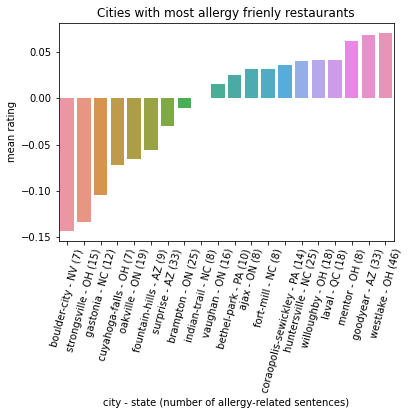

In [16]:
negative_cities = get_groups_with_negative_sentiment(business_sentiment, ['state','region_name'])
negative_cities = negative_cities[negative_cities['sentiment_score']['count'] > 5].head(20)

ax = sns.barplot(
    y=negative_cities['sentiment_score']['mean'],
    x=(negative_cities['region_name'] + ' - ' + negative_cities['state']) + \
        ' (' + negative_cities['sentiment_score']['count'].astype(str) + ')'
    )
ax.set(
    title='Cities with most allergy frienly restaurants', 
    xlabel='city - state (number of allergy-related sentences)',     
    ylabel='mean rating'
    )
ax.set_xticklabels(ax.get_xticklabels(), rotation=75)
ax

### Aggregate by city AND allergy

In [9]:
business_allergen_sentiment = aggregate_sentiment_by_business_allergy(data, allergen_cols)
business_allergen_sentiment = business_allergen_sentiment.merge(
     businesses[['business_id', 'city', 'state']],
     on='business_id',
     how='left'
     )  

/Users/kristenkeller/anaconda/envs/restaurant-reviews-allergy-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


In [10]:
get_groups_with_positive_sentiment(
    business_allergen_sentiment[business_allergen_sentiment['allergen'] == 'is_gluten'], 
    'state'
    )

/Users/kristenkeller/anaconda/envs/restaurant-reviews-allergy-dev/lib/python3.7/site-packages/ipykernel/ipkernel.py:287: DeprecationWarning: `should_run_async` will not call `transform_cell` automatically in the future. Please pass the result to `transformed_cell` argument and any exception that happen during thetransform in `preprocessing_exc_tuple` in IPython 7.17 and above.
  and should_run_async(code)


state sentiment_score                
                  median count      mean
4     NV            0.25   449  0.366927
1     AZ            0.25   618  0.241100
3     NC            0.25   137  0.220803
8     QC            0.25    79  0.199367
7     PA            0.25   135  0.198148
6     ON            0.25   339  0.148968
9     SC            0.00    13  0.134615
0     AB            0.25    83  0.117470
5     OH            0.25   132  0.113636
2     IL            0.25    20  0.112500
10    WI            0.25    67  0.067164